In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import traintest as tt
import models
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from sklearn import mixture, preprocessing, datasets
from copy import deepcopy
%load_ext autoreload
%autoreload 2

In [2]:
# Generate dataset
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df=(df-df.min())/(df.max()-df.min()) # normalize [0,1]
df['labels'] = labels
data = torch.tensor(df[['feature_1', 'feature_2']].to_numpy(), dtype=torch.float) 
device=torch.device('cuda:0')

<Axes: xlabel='feature_1', ylabel='feature_2'>

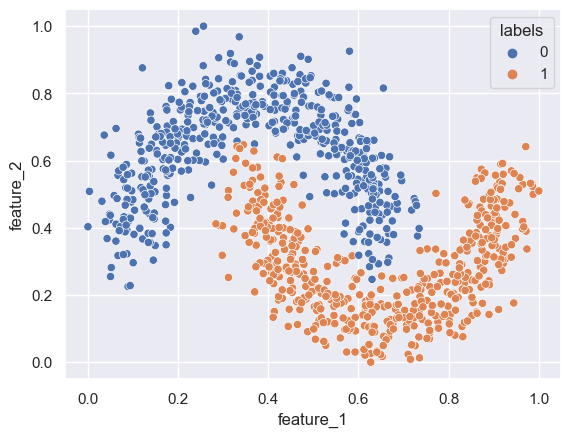

In [3]:
sns.set_theme()
sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)

In [4]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [5]:
df2 = pd.DataFrame(gmm.mu.detach(), columns=['feature_1', 'feature_2'])
df2['labels'] = ['gmm_center']*n_centers

In [6]:
# make grid for contour
x = y = np.arange(-.03, 1.03, 0.01)
points = []
for xx in x:
    for yy in y:
        points.append([xx, yy])

<Axes: xlabel='feature_1', ylabel='feature_2'>

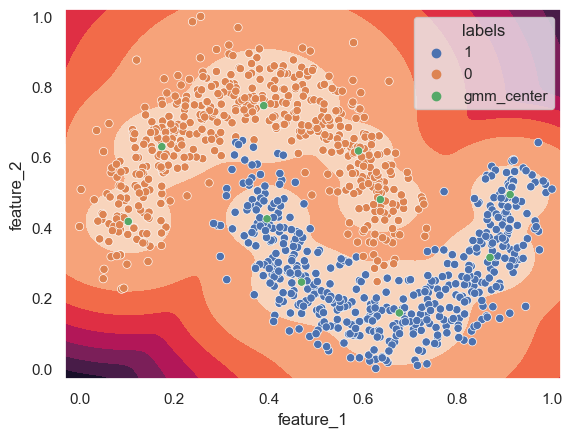

In [7]:
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
plt.contourf(x,y,z)
sns.scatterplot(data = pd.concat([df, df2], axis=0), x = 'feature_1', y = 'feature_2', hue = 'labels')

### MLP Classifier

In [13]:
label = torch.tensor(labels, dtype=torch.int64)
train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

In [14]:
class TwoMoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]
loss = []
acc = []
optimizer = optim.Adam(param_groups)

for epoch in range(200):
    
    l,a,_= tt.train_plain(net.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1)
    loss.append(l)
    acc.append(a)
    if a > .98:
        break # converged

Text(0.5, 0, 'Epoch')

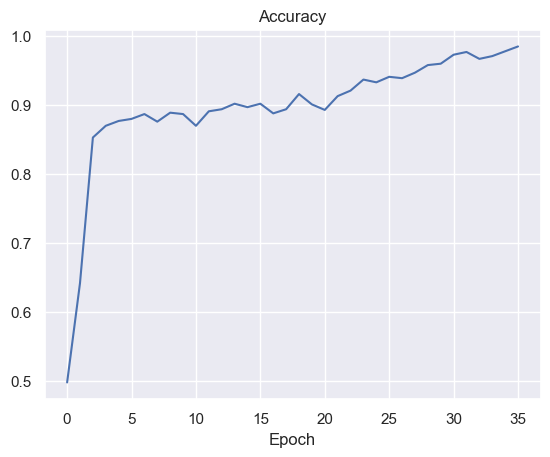

In [15]:
sns.lineplot(acc)
plt.title('Accuracy')
plt.xlabel('Epoch')

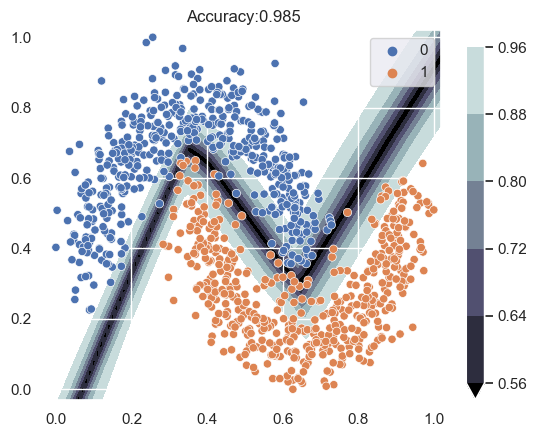

In [16]:
tt.plot_conf(net, data, label, device)

### CCU Robust Model Learning

In [8]:
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [9]:
gmm.mu.requires_grad_(False) # turn of learning of centers

Parameter containing:
tensor([[0.4699, 0.2452],
        [0.1741, 0.6298],
        [0.5905, 0.6179],
        [0.8688, 0.3153],
        [0.1031, 0.4175],
        [0.3968, 0.4249],
        [0.9114, 0.4938],
        [0.6368, 0.4799],
        [0.3898, 0.7465],
        [0.6769, 0.1577]])

In [17]:
data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000, dtype=torch.int64)


train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)

In [18]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

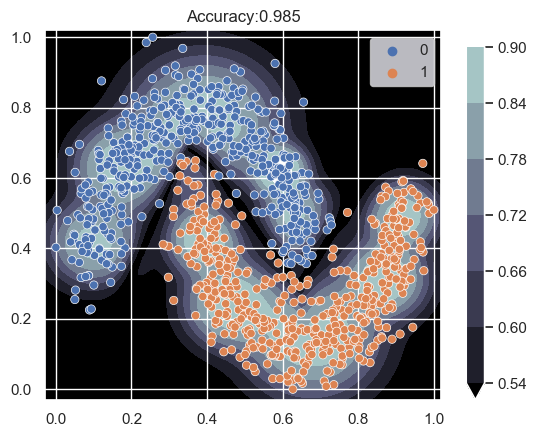

In [19]:
tt.plot_conf(CCU.to(device), data, label, device)

In [20]:
for epoch in range(250):
    l,a,_= tt.train_CEDA_gmm(CCU.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1, noise_loader=train_loader_out)

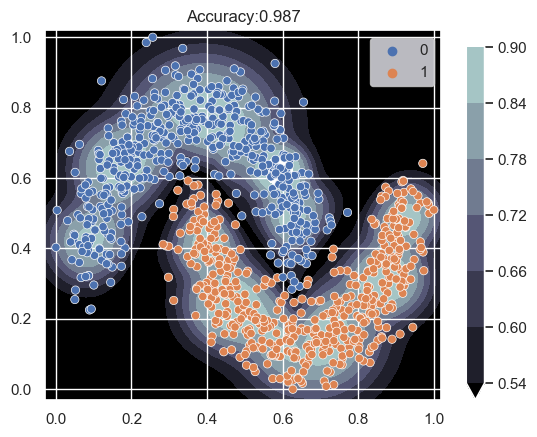

In [21]:
tt.plot_conf(CCU.to(device), data, label, device)

In [22]:
centers = CCU.mm.mu.detach().cpu()

<Axes: xlabel='feature_1', ylabel='feature_2'>

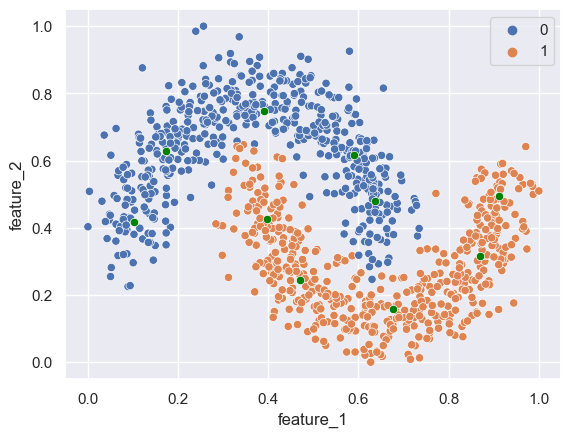

In [23]:
sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)
sns.scatterplot(x=centers[:,0], y=centers[:,1], color='green')

## RBFNet Classifier

In [24]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x):
    return torch.norm(x, p=2, dim=-1)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()


class TwoMoonsRBFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=6,
                               out_features_dim=6,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True)
        self.fc1 = nn.Linear(6, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [25]:
def fun(x, y, center, shape):
    diff = center.T - [x, y]
    r = np.linalg.norm(diff, axis=0)
    return np.exp(-(shape * r) ** 2)

In [26]:
lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsRBFNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)

for epoch in range(100):
     tt.train_plain(net.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1,
                   )


In [27]:
kernels = net.rbf.get_kernels_centers.cpu().numpy()
shapes = net.rbf.get_shapes.cpu().numpy()

In [28]:
kernels

array([[-0.49825257, -0.55792814],
       [ 1.493187  , -0.7536571 ],
       [ 0.18848701,  0.85279924],
       [-0.5300516 , -0.53269684],
       [ 0.34521848,  0.4561746 ],
       [-0.34232077, -0.6096253 ]], dtype=float32)

In [29]:
shapes

array([2.2866342, 1.2822177, 2.4468515, 2.2686422, 7.2615676, 2.2053192],
      dtype=float32)

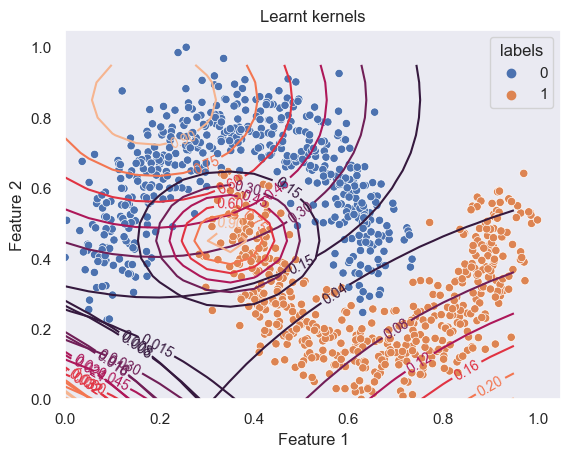

In [30]:
x = y = np.arange(0,1, 0.05)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()
for i in range(6):
    center = kernels[i][:, None].repeat(400, axis=1).T
    zs = np.array(fun(X.ravel(), Y.ravel(), center, shapes[i].repeat(400)))
    Z = zs.reshape(X.shape)

    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Learnt kernels')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid()
sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)
plt.show()

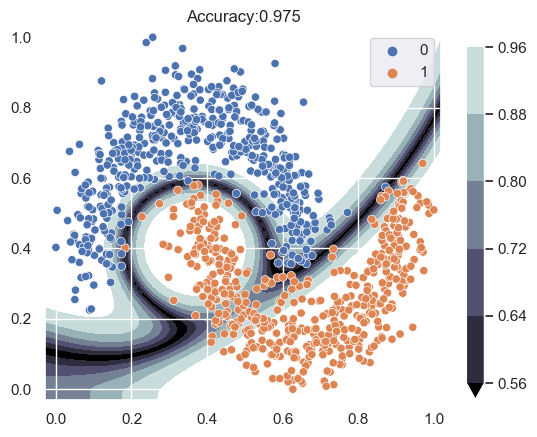

In [31]:
tt.plot_conf(net, data, label, device)

### Compare RBF output to GMM output

In [37]:
sample = torch.tensor([[.4,.4],[.7,.8]])
net.to('cpu')

TwoMoonsRBFNet(
  (rbf): RBFLayer()
  (fc1): Linear(in_features=6, out_features=2, bias=True)
)

In [38]:
net.rbf(sample) # rbf has 6 centers, gives distance from each center row wise

tensor([[ 3.3689e-01, -3.3088e-05, -6.0993e-04,  5.1111e-03,  1.4063e+00,
         -1.6081e-01],
        [-4.0555e-01, -6.8196e-04, -3.7090e-06, -8.9949e-03, -1.8652e-02,
          1.8837e+00]], grad_fn=<SumBackward1>)

In [41]:
rc = net.rbf.get_kernels_centers
rvar = net.rbf.get_shapes
rw = net.rbf.get_weights

In [39]:
gmm(sample)# gmm has 10 centers, gives value in column for likelihood of each point from sample

tensor([[ -2.1801, -42.8639],
        [-12.1915, -38.4142],
        [-28.6263, -14.5983],
        [-32.7997, -38.2839],
        [-10.3552, -63.6895],
        [  1.2723, -42.6750],
        [-52.6265, -26.2984],
        [ -9.5702, -17.2445],
        [ -4.7870,  -3.7176],
        [ -7.2746, -24.9891]], grad_fn=<SubBackward0>)

In [ ]:
gc = gmm.mu
gvar = gmm.logvar
gw = gmm.alpha

## RBF with CCU (with GMM and RBF seperate)

In [35]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

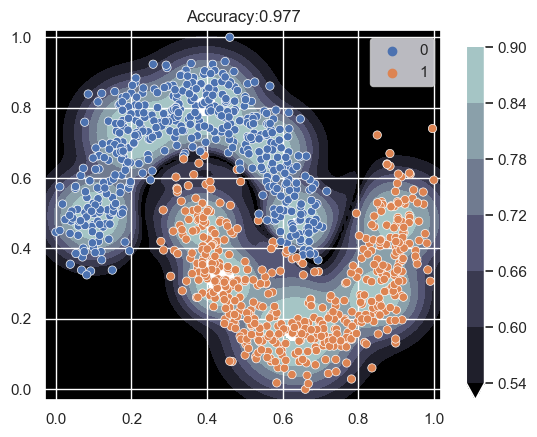

In [37]:
tt.plot_conf(CCU.to(device),data, label, device)

### Combine RBF and GMM centers